In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

## trial data

offsets (0.2, -0.12)


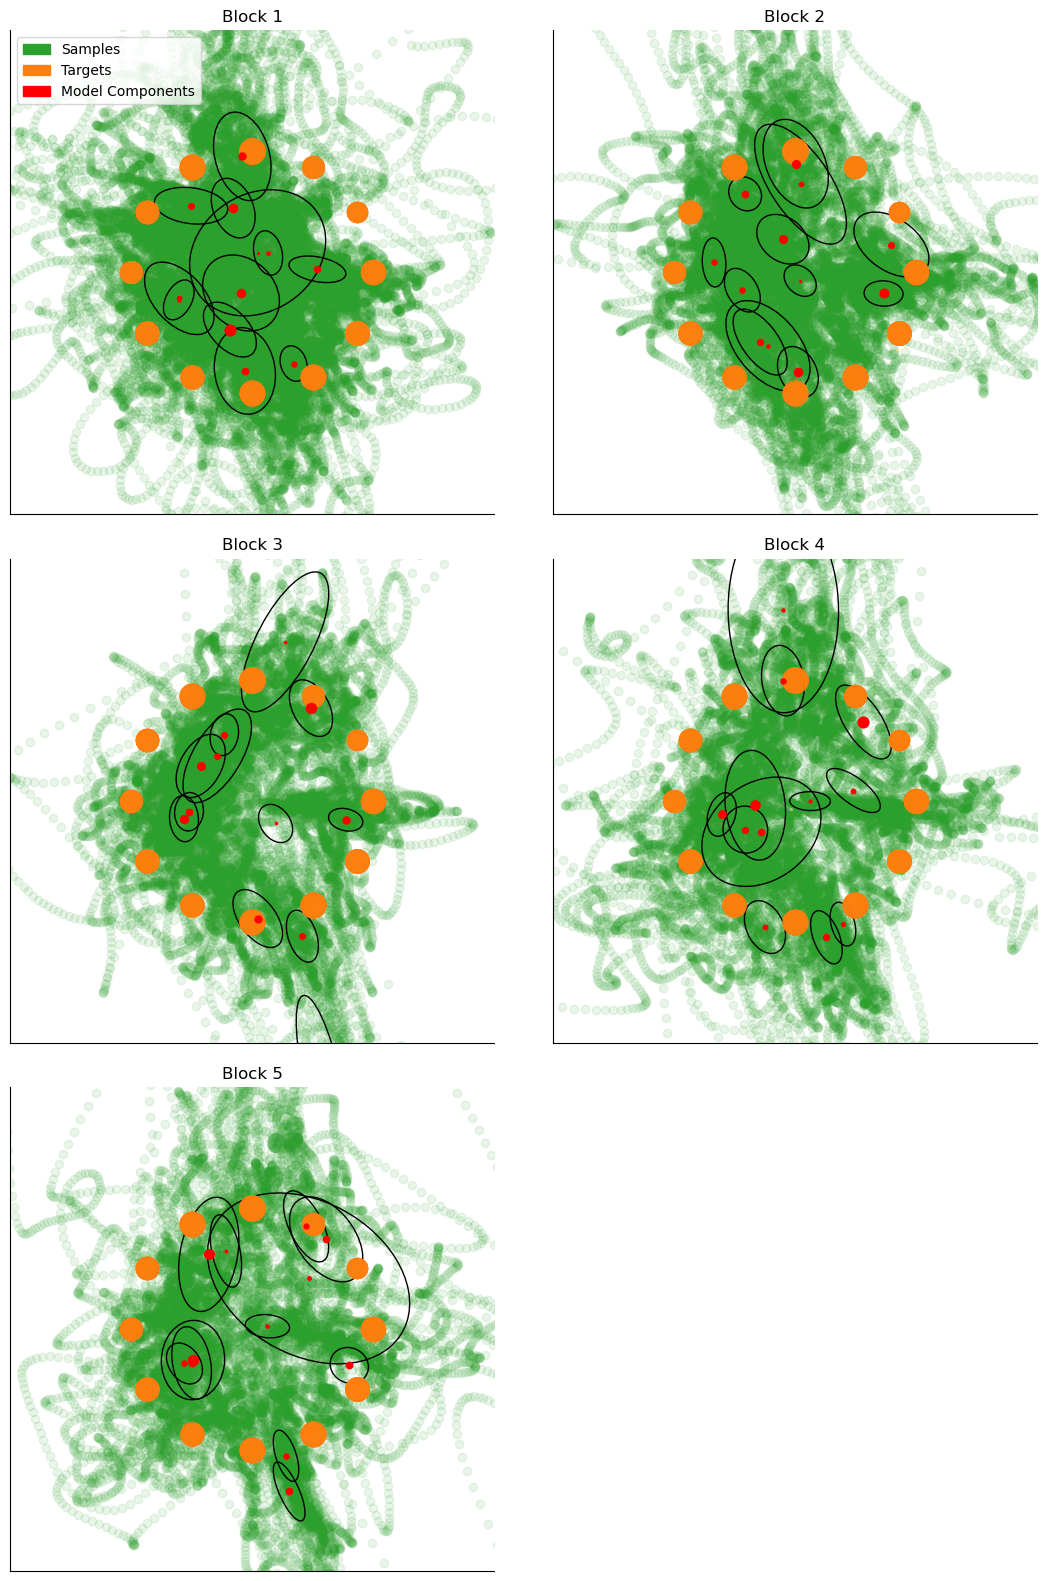

In [4]:
def plot_trial_models(subject_idx,color="tab:green"):
    models = model.load_log_trial_models(subject_idx)
    stack = analysis.load_trial_stack(subject_idx=subject_idx)
    print("offsets", offsets[subject_idx])
    fig, model_axes = plt.subplots(3,2,figsize=(11,16))
    fig.tight_layout()
    model_axes = model_axes.ravel()
    hits = analysis.get_subject_target_hits(subject_idx)
    hit_weights = hits / hits.sum()
    block_chunks = [(i,j) for i,j in zip(range(0,46,9),range(9,46,9))]
    decoder = subjects[subject_idx].decoder[-2:,:]
    for i, m in enumerate(models):
        model_ax = model_axes[i]
        chunk_samples = decoder @ stack[block_chunks[i][0]:block_chunks[i][1]].transpose(0,1,3,2).reshape(-1,64).T
        t, = model_ax.plot(chunk_samples[0]-offsets[subject_idx][0],chunk_samples[1]-offsets[subject_idx][1],"o",color=color,alpha=0.1,zorder=0)
        for mean, covariance, weight in zip(m.means_,m.covariances_,m.weights_):
        # for mean, covariance, weight in zip(log_model.means_,log_model.covariances_,log_model.weights_):
            log_mean = analysis.make_lognormal_mean(mean.reshape(-1,1),covariance)
            log_cov = analysis.make_lognormal_covariance(mean.reshape(-1,1),covariance)
            log_mean = model.zero_ch_56_mean(log_mean.reshape(-1,1))
            log_cov = model.zero_ch_56_cov(log_cov)
            tm = model.transform_mean(decoder, log_mean)
            tc = model.transform_covariance(decoder, log_cov)
            model_ax.plot(tm[0]-offsets[subject_idx][0],tm[1]-offsets[subject_idx][1],'ro',zorder=100,markersize=weight*50)
            r = plot.plot_weighted_targets(model_ax,hit_weights*200,color="tab:orange",alpha=0.3)
            e = plot.plot_confidence_ellipse([tm[0]-offsets[subject_idx][0],tm[1]-offsets[subject_idx][1]],tc,model_ax,n_std=0.5)
            model_ax.set_aspect("equal")
            model_ax.set_title(f"Block {i+1}")
            model_ax.set_xticks([])
            model_ax.set_yticks([])
        # model_ax.plot(0,0,"bo")
        model_ax.set_ylim([-2,2])
        model_ax.set_xlim([-2,2])
        handles = [patches.Patch(color=color),patches.Patch(color="tab:orange"),patches.Patch(color="red")]
        model_axes[0].legend(handles=handles, labels=["Samples", "Targets", "Model Components"],loc=2)
    model_axes[-1].set_axis_off()
    return fig

subject_35_trial_fig = plot_trial_models(35)

In [5]:
plot.save_figure(subject_35_trial_fig,"subject_35_trial_gmm",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_35_trial_gmm.pdf


offsets (0.03, 0.0)


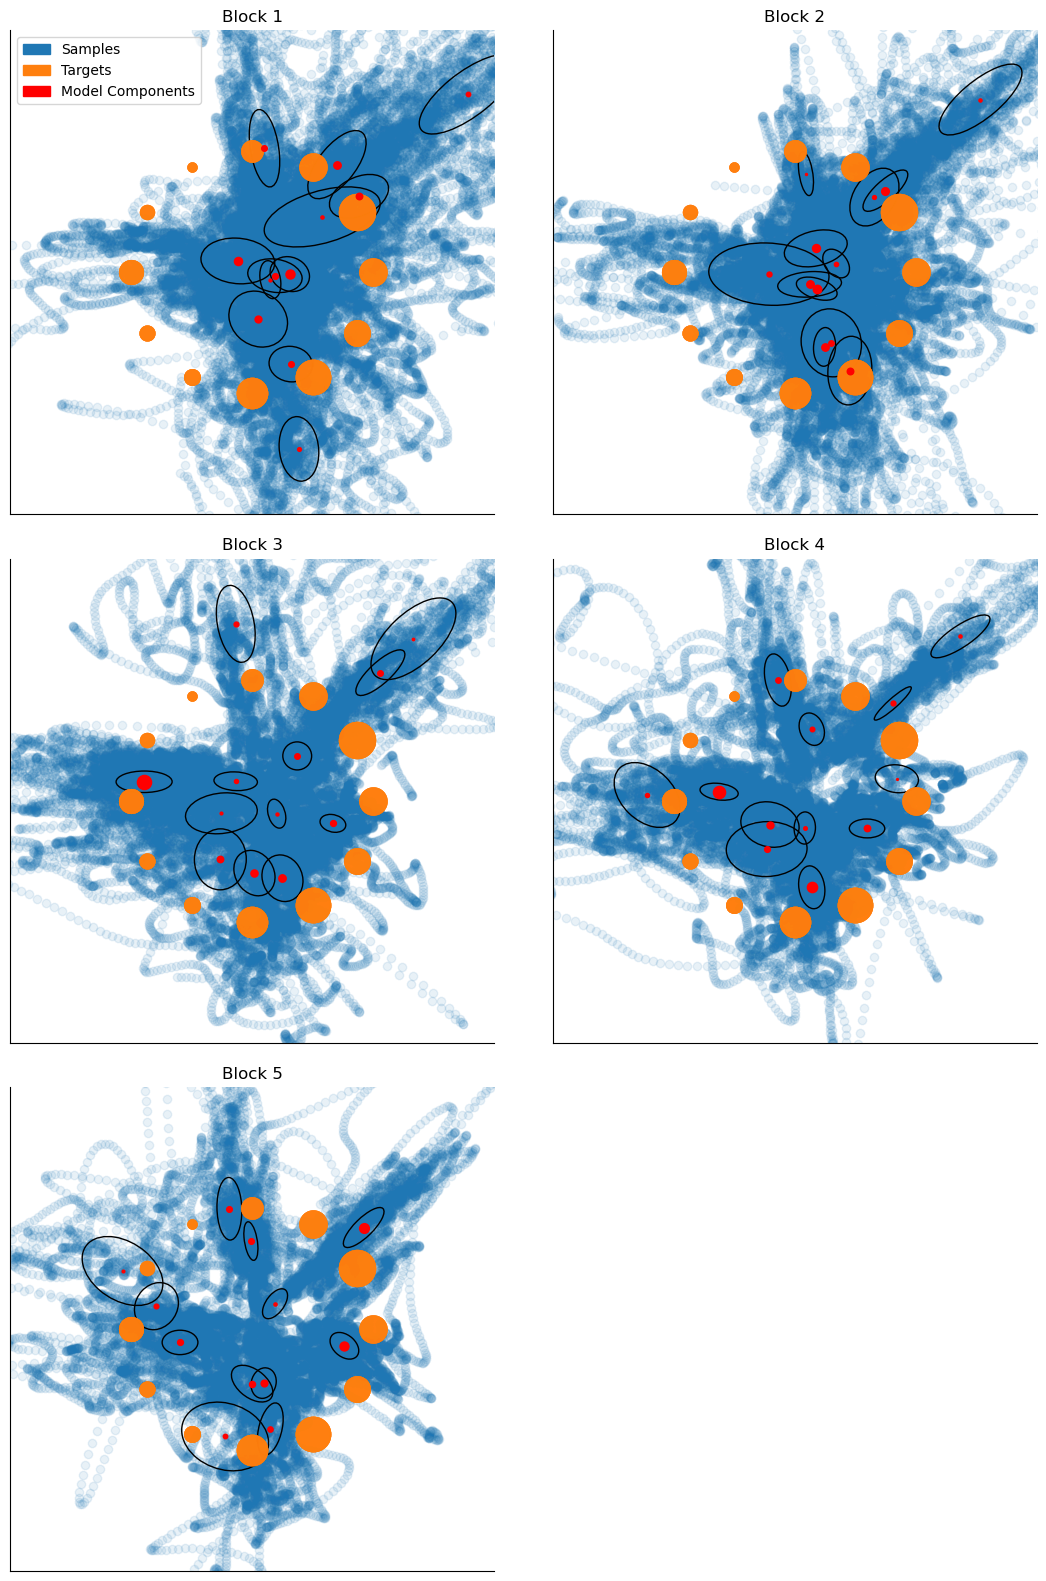

In [6]:
subject_1_trial_fig = plot_trial_models(1,color="tab:blue")

In [7]:
plot.save_figure(subject_1_trial_fig,"subject_1_trial_gmm",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_1_trial_gmm.pdf


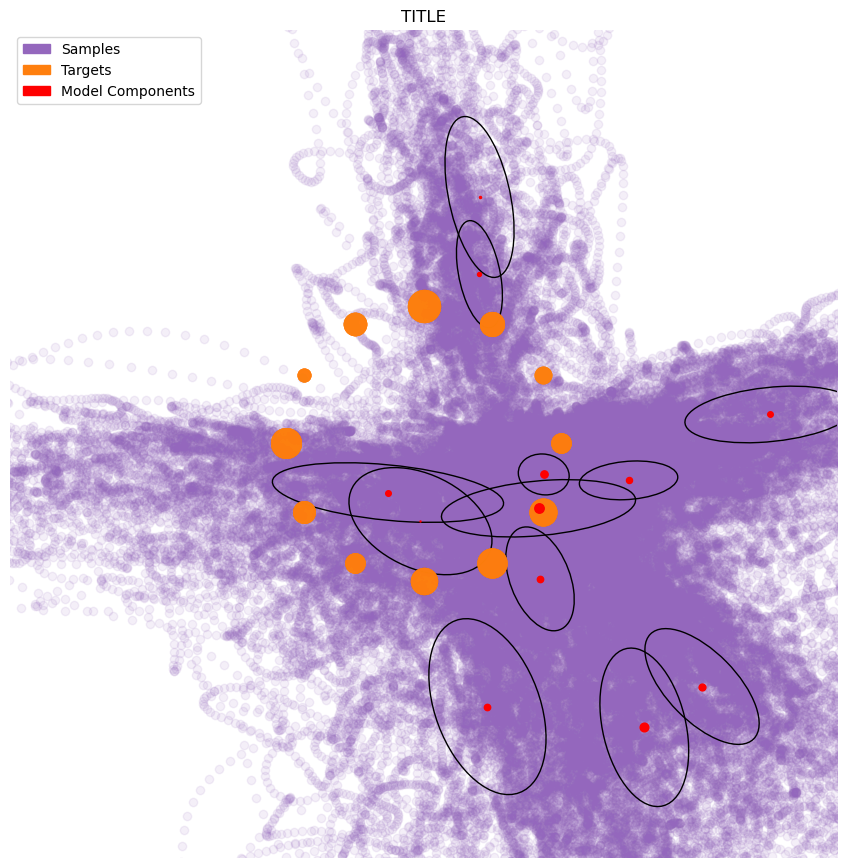

In [8]:
def plot_calibration_model(subject_idx,color="tab:purple"):
    m = model.load_log_calibration_models(subject_idx)[0]
    stack = np.load("../subject_filtered_calibration_stacks.npy")[subject_idx]
    fig, model_ax = plt.subplots(1,1,figsize=(9,9))
    fig.tight_layout()
    hits = analysis.get_subject_target_hits(subject_idx)
    hit_weights = hits / hits.sum()
    decoder = subjects[subject_idx].decoder[-2:,:]
    samples = decoder @ stack.transpose(0,1,3,2).reshape(-1,64).T
    t, = model_ax.plot(samples[0],samples[1],"o",color=color,alpha=0.1,zorder=0)
    for mean, covariance, weight in zip(m.means_,m.covariances_,m.weights_):
    # for mean, covariance, weight in zip(log_model.means_,log_model.covariances_,log_model.weights_):
        log_mean = analysis.make_lognormal_mean(mean.reshape(-1,1),covariance)
        log_cov = analysis.make_lognormal_covariance(mean.reshape(-1,1),covariance)
        log_mean = model.zero_ch_56_mean(log_mean.reshape(-1,1))
        log_cov = model.zero_ch_56_cov(log_cov)
        tm = model.transform_mean(decoder, log_mean)
        tc = model.transform_covariance(decoder, log_cov)
        model_ax.plot(tm[0],tm[1],'ro',zorder=100,markersize=weight*50)
        r = plot.plot_weighted_targets(model_ax,hit_weights*200,color="tab:orange",alpha=0.3)
        e = plot.plot_confidence_ellipse(tm,tc,model_ax,n_std=0.5)
        model_ax.set_aspect("equal")
        model_ax.set_title(f"TITLE")
        model_ax.set_xticks([])
        model_ax.set_yticks([])
    # model_ax.plot(0,0,"bo")
    model_ax.set_ylim([-3,3])
    model_ax.set_xlim([-3,3])
    handles = [patches.Patch(color=color),patches.Patch(color="tab:orange"),patches.Patch(color="red")]
    model_ax.legend(handles=handles, labels=["Samples", "Targets", "Model Components"],loc=2)
    model_ax.set_axis_off()
    return fig

subject_9_calibration_fig = plot_calibration_model(9)

In [9]:
plot.save_figure(subject_9_calibration_fig, "subject_9_calibration_gmm", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_9_calibration_gmm.pdf


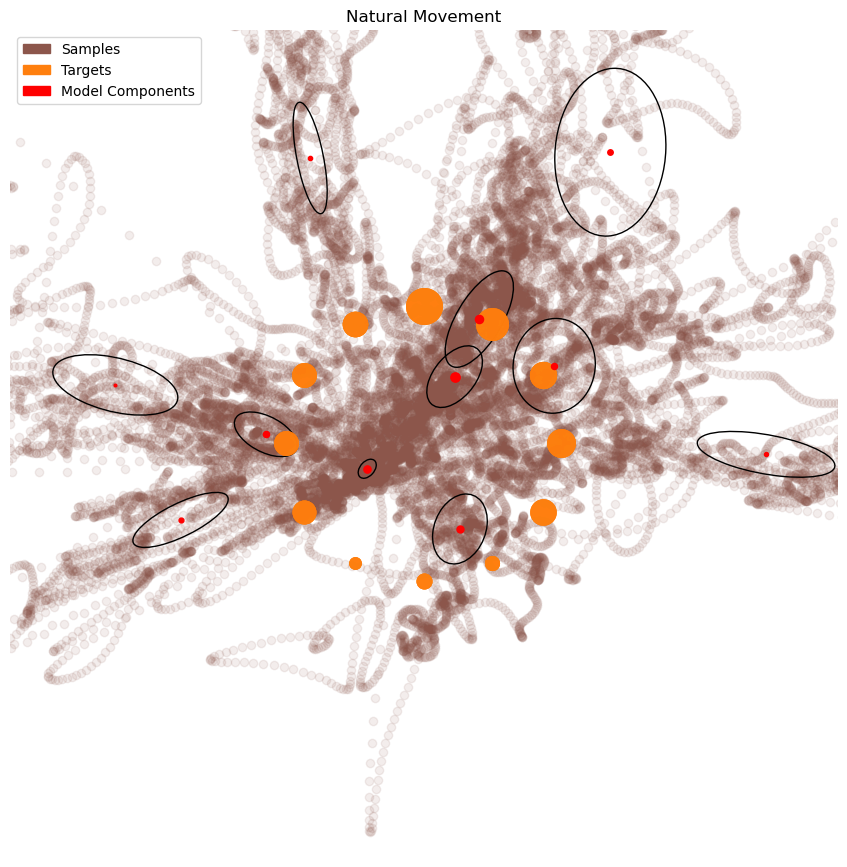

In [10]:
def plot_movement_model(subject_idx,color="tab:brown"):
    m = model.load_log_movement_models(subject_idx)[0]
    stack = np.load("../subject_filtered_movement_stacks.npy")[subject_idx]
    fig, model_ax = plt.subplots(1,1,figsize=(9,9))
    fig.tight_layout()
    hits = analysis.get_subject_target_hits(subject_idx)
    hit_weights = hits / hits.sum()
    decoder = subjects[subject_idx].decoder[-2:,:]
    samples = decoder @ stack.transpose(0,1,3,2).reshape(-1,64).T
    t, = model_ax.plot(samples[0],samples[1],"o",color=color,alpha=0.1,zorder=0)
    for mean, covariance, weight in zip(m.means_,m.covariances_,m.weights_):
    # for mean, covariance, weight in zip(log_model.means_,log_model.covariances_,log_model.weights_):
        log_mean = analysis.make_lognormal_mean(mean.reshape(-1,1),covariance)
        log_cov = analysis.make_lognormal_covariance(mean.reshape(-1,1),covariance)
        log_mean = model.zero_ch_56_mean(log_mean.reshape(-1,1))
        log_cov = model.zero_ch_56_cov(log_cov)
        tm = model.transform_mean(decoder, log_mean)
        tc = model.transform_covariance(decoder, log_cov)
        model_ax.plot(tm[0],tm[1],'ro',zorder=100,markersize=weight*50)
        r = plot.plot_weighted_targets(model_ax,hit_weights*200,color="tab:orange",alpha=0.3)
        e = plot.plot_confidence_ellipse(tm,tc,model_ax,n_std=0.5)
        model_ax.set_aspect("equal")
        model_ax.set_title(f"Natural Movement")
        model_ax.set_xticks([])
        model_ax.set_yticks([])
    # model_ax.plot(0,0,"bo")
    model_ax.set_ylim([-3,3])
    model_ax.set_xlim([-3,3])
    handles = [patches.Patch(color=color),patches.Patch(color="tab:orange"),patches.Patch(color="red")]
    model_ax.legend(handles=handles, labels=["Samples", "Targets", "Model Components"],loc=2)
    model_ax.set_axis_off()
    return fig

subject_10_movement_fig = plot_movement_model(10)

In [11]:
plot.save_figure(subject_10_movement_fig, "subject_10_movement_gmm", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_10_movement_gmm.pdf


# single subject, all models

In [12]:
def plot_model(model, ax, color, cov_color="k",label=None,**kwargs):
    for i, (mean, weight, covariance) in enumerate(zip(model.means, model.weights, model.covariances)):
        if i == model.means.shape[0]-1:
            ax.plot(mean[0],mean[1],"o",color=color,label=label,**kwargs)
        else:
            ax.plot(mean[0],mean[1],"o",color=color,**kwargs)
        plot.plot_confidence_ellipse(mean,covariance,edgecolor=cov_color,ax=ax,n_std=0.5,**kwargs)

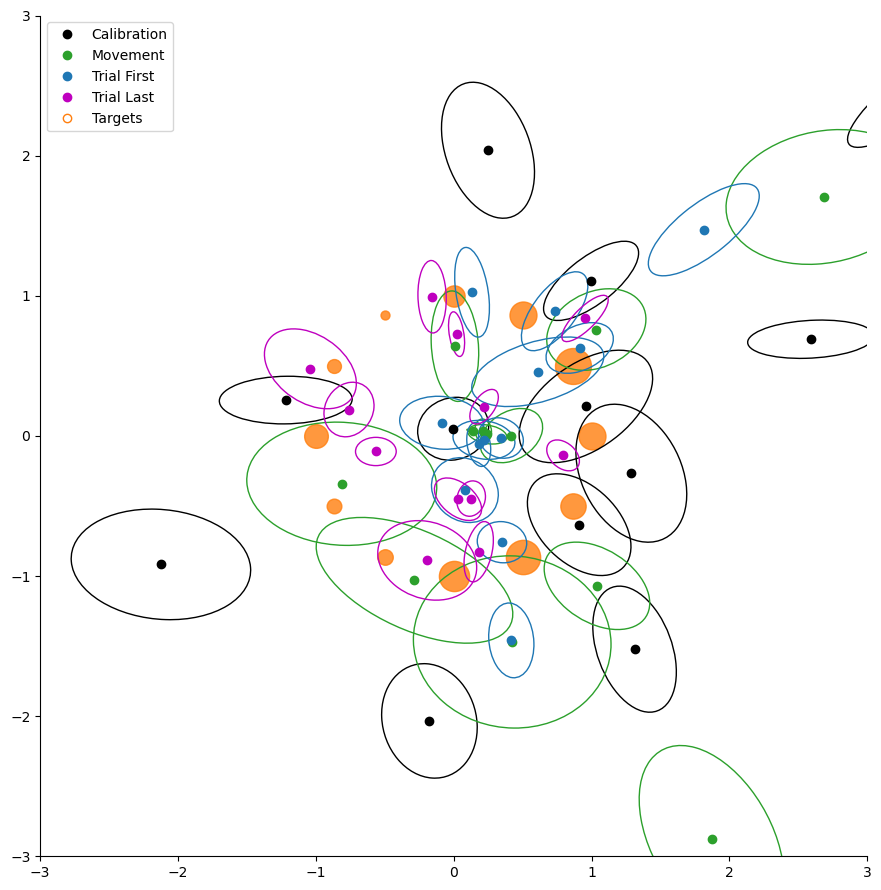

In [13]:
subject_idx = 1

calibration_model = model.load_log_calibration_models(subject_idx=subject_idx)[0]
trial_model = model.load_log_trial_models(subject_idx=subject_idx)[0]
trial_model_last = model.load_log_trial_models(subject_idx=subject_idx)[-1]
movement_model = model.load_log_movement_models(subject_idx=subject_idx)[0]

decoder = subjects[subject_idx].decoder[-2:,:]

log_calibration_model = model.log_model(calibration_model)
log_movement_model = model.log_model(movement_model)
log_trial_model = model.log_model(trial_model)
log_trial_model_last = model.log_model(trial_model_last)

log_calibration_model_2d = model.model_2d(log_calibration_model,decoder)
log_movement_model_2d = model.model_2d(log_movement_model,decoder)
log_trial_model_2d = model.model_2d(log_trial_model,decoder)
log_trial_model_last_2d = model.model_2d(log_trial_model_last,decoder)

subject_1_fig, ax = plt.subplots(figsize=(9,9))
subject_1_fig.tight_layout()
ax.set_ylim([-3,3])
ax.set_xlim([-3,3])

models = [calibration_model,movement_model,trial_model,trial_model_last]
pairs = model.closest_pairs_euclidean(models)
models_2d = [log_calibration_model_2d, log_movement_model_2d, log_trial_model_2d, log_trial_model_last_2d]

plot_model(log_calibration_model_2d,plt.gca(),"k",cov_color="k",label="Calibration")
plot_model(log_movement_model_2d,plt.gca(),"tab:green",cov_color="tab:green",label="Movement")
plot_model(log_trial_model_2d,plt.gca(),"tab:blue",cov_color="tab:blue",label="Trial First")
plot_model(log_trial_model_last_2d,plt.gca(),"m",cov_color="m",label="Trial Last")

hits = analysis.get_subject_target_hits(subject_idx)
hit_weights = hits / hits.sum()
plot.plot_weighted_targets(ax,hit_weights*200,color="tab:orange",alpha=0.8,markerfacecolor="tab:orange",zorder=0)
hs, ls = ax.get_legend_handles_labels()
hs.append(lines.Line2D([0], [0], marker='o', color='tab:orange', label='Circle',
                        markerfacecolor="none", markersize=6),)
ls.append("Targets")

plt.legend(hs,ls)

In [14]:
plot.save_figure(subject_1_fig, "subject_1_gmms", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_1_gmms.pdf


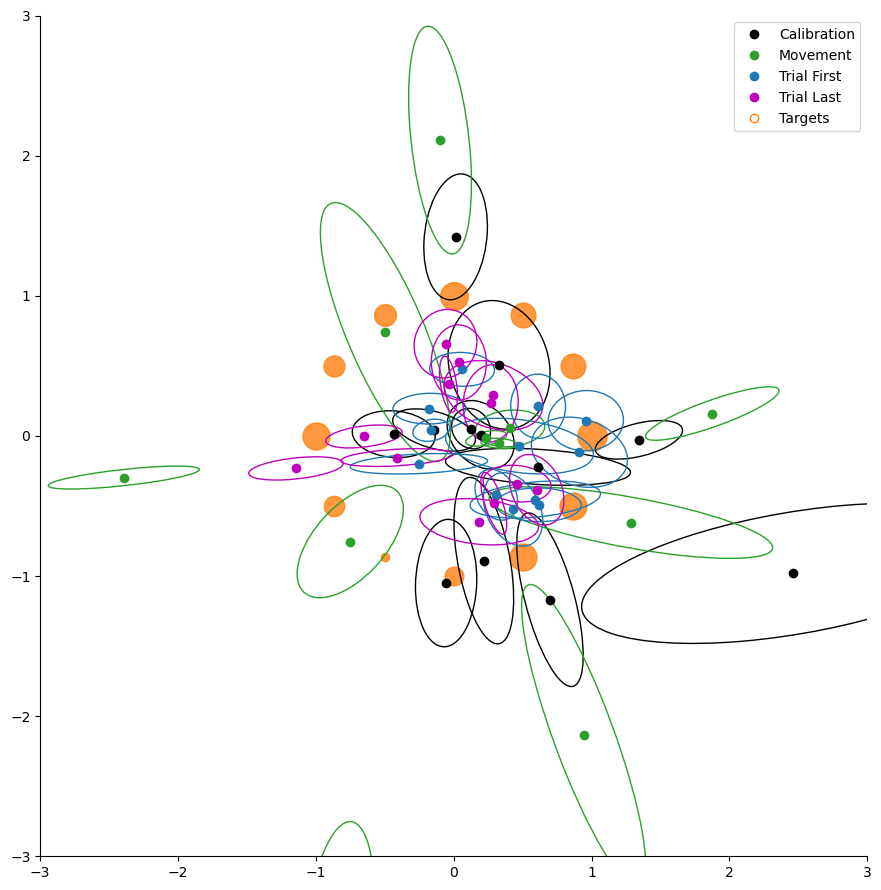

In [22]:
subject_idx = 14

calibration_model = model.load_log_calibration_models(subject_idx=subject_idx)[0]
trial_model = model.load_log_trial_models(subject_idx=subject_idx)[0]
trial_model_last = model.load_log_trial_models(subject_idx=subject_idx)[-1]
movement_model = model.load_log_movement_models(subject_idx=subject_idx)[0]

decoder = subjects[subject_idx].decoder[-2:,:]

log_calibration_model = model.log_model(calibration_model)
log_movement_model = model.log_model(movement_model)
log_trial_model = model.log_model(trial_model)
log_trial_model_last = model.log_model(trial_model_last)

log_calibration_model_2d = model.model_2d(log_calibration_model,decoder)
log_movement_model_2d = model.model_2d(log_movement_model,decoder)
log_trial_model_2d = model.model_2d(log_trial_model,decoder)
log_trial_model_last_2d = model.model_2d(log_trial_model_last,decoder)

subject_14_fig, ax = plt.subplots(figsize=(9,9))
subject_14_fig.tight_layout()
ax.set_ylim([-3,3])
ax.set_xlim([-3,3])

models = [calibration_model,movement_model,trial_model,trial_model_last]
pairs = model.closest_pairs_euclidean(models)
models_2d = [log_calibration_model_2d, log_movement_model_2d, log_trial_model_2d, log_trial_model_last_2d]

plot_model(log_calibration_model_2d,plt.gca(),"k",cov_color="k",label="Calibration")
plot_model(log_movement_model_2d,plt.gca(),"tab:green",cov_color="tab:green",label="Movement")
plot_model(log_trial_model_2d,plt.gca(),"tab:blue",cov_color="tab:blue",label="Trial First")
plot_model(log_trial_model_last_2d,plt.gca(),"m",cov_color="m",label="Trial Last")

hits = analysis.get_subject_target_hits(subject_idx)
hit_weights = hits / hits.sum()
plot.plot_weighted_targets(ax,hit_weights*200,color="tab:orange",alpha=0.8,zorder=0)
hs, ls = ax.get_legend_handles_labels()
hs.append(lines.Line2D([0], [0], marker='o', color='tab:orange', label='Circle',
                        markerfacecolor="none", markersize=6),)
ls.append("Targets")

plt.legend(hs,ls)

In [16]:
plot.save_figure(subject_14_fig, "subject_14_gmms",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_14_gmms.pdf


# track trial models

In [17]:
np.argsort(mean_rewards)[::-1]

subject
45    29
44     6
43    37
42    11
41     0
40    16
39    22
38    35
37    36
36    17
35    33
34    32
33    15
32    24
31     3
30    41
29    14
28    21
27    40
26    18
25    30
24     1
23    42
22    27
21    31
20    10
19    44
18    43
17     9
16     2
15    19
14     5
13    28
12     8
11    38
10    13
9      7
8     25
7     45
6     12
5     20
4     39
3     26
2     34
1      4
0     23
Name: reward, dtype: int64

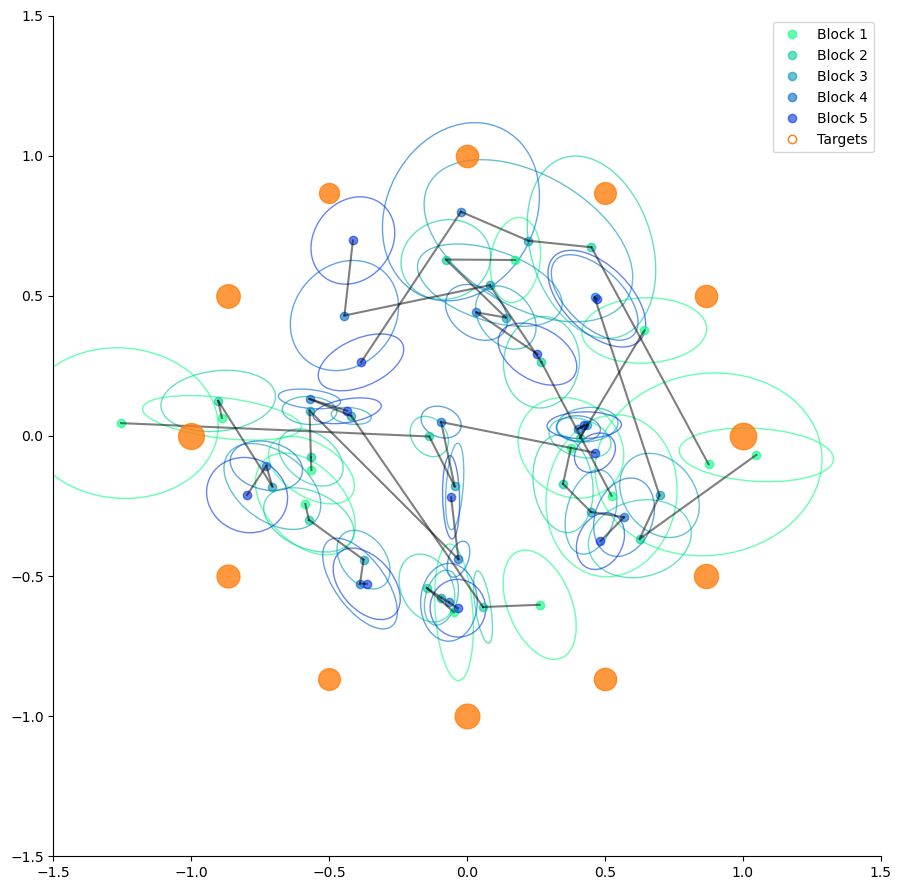

In [18]:
subject_idx = 37
decoder = subjects[subject_idx].decoder[-2:,:]

trial_models = model.load_log_trial_models(subject_idx=subject_idx)
log_trial_models = [model.log_model(m) for m in trial_models]
log_trial_models_2d = [model.model_2d(m,decoder) for m in log_trial_models]


pairs = model.closest_pairs_euclidean(trial_models)

subject_37_fig, ax = plt.subplots(figsize=(9,9))
subject_37_fig.tight_layout()
ax.set_ylim([-1.5,1.5])
ax.set_xlim([-1.5,1.5])


cmap = mpl.colormaps["winter_r"]
for i, m in enumerate(log_trial_models_2d):
    plot_model(m,plt.gca(),cmap(i/len(log_trial_models_2d)),cov_color=cmap(i/len(log_trial_models_2d)),label=f"Block {i+1}",alpha=0.6)

for p, m1, m2 in zip(pairs, log_trial_models_2d[:-1],log_trial_models_2d[1:]):
    plot.plot_pairs(p,m1.means,m2.means,ax=plt.gca(),alpha=0.5)

hits = analysis.get_subject_target_hits(subject_idx)
hit_weights = hits / hits.sum()
plot.plot_weighted_targets(ax,hit_weights*200,color="tab:orange",alpha=0.8)
hs, ls = ax.get_legend_handles_labels()
hs.append(lines.Line2D([0], [0], marker='o', color='tab:orange', label='Circle',
                        markerfacecolor="none", markersize=6),)
ls.append("Targets")

plt.legend(hs,ls)


In [19]:
plot.save_figure(subject_37_fig, "subject_37_trial_gmms", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_37_trial_gmms.pdf


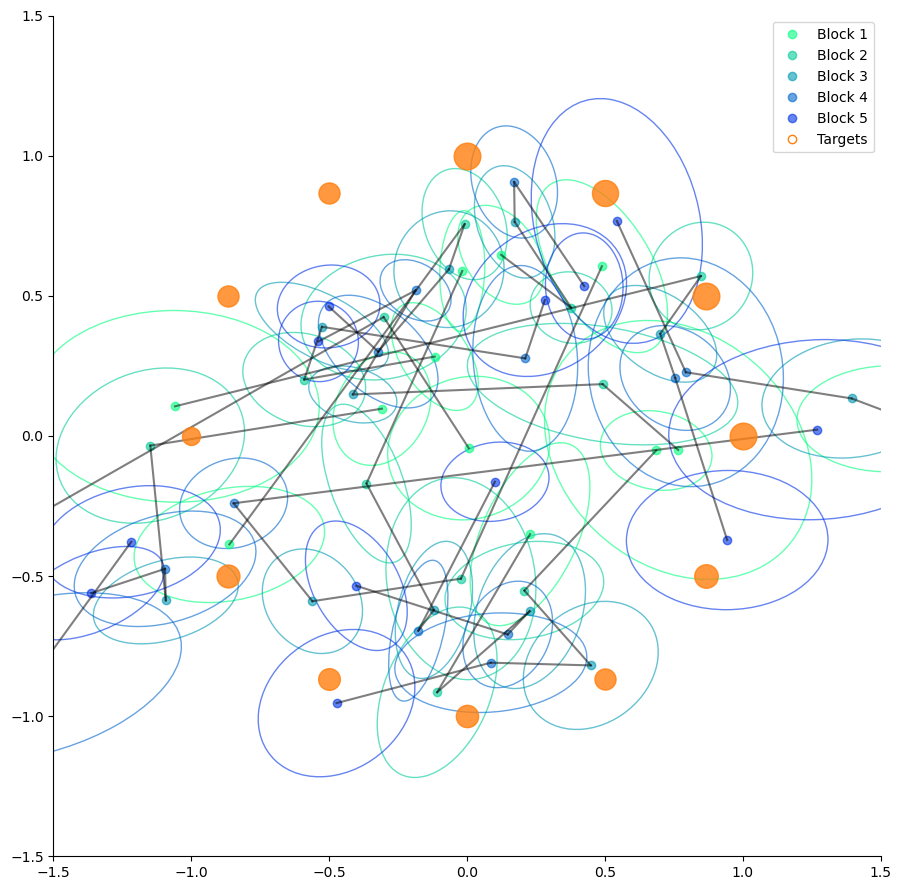

In [20]:
subject_idx = 42
decoder = subjects[subject_idx].decoder[-2:,:]

trial_models = model.load_log_trial_models(subject_idx=subject_idx)
log_trial_models = [model.log_model(m) for m in trial_models]
log_trial_models_2d = [model.model_2d(m,decoder) for m in log_trial_models]


pairs = model.closest_pairs_euclidean(trial_models)

subject_42_fig, ax = plt.subplots(figsize=(9,9))
subject_42_fig.tight_layout()
ax.set_ylim([-1.5,1.5])
ax.set_xlim([-1.5,1.5])


cmap = mpl.colormaps["winter_r"]
for i, m in enumerate(log_trial_models_2d):
    plot_model(m,plt.gca(),cmap(i/len(log_trial_models_2d)),cov_color=cmap(i/len(log_trial_models_2d)),label=f"Block {i+1}",alpha=0.6)

for p, m1, m2 in zip(pairs, log_trial_models_2d[:-1],log_trial_models_2d[1:]):
    plot.plot_pairs(p,m1.means,m2.means,ax=plt.gca(),alpha=0.5)

hits = analysis.get_subject_target_hits(subject_idx)
hit_weights = hits / hits.sum()
plot.plot_weighted_targets(ax,hit_weights*200,color="tab:orange",alpha=0.8)
hs, ls = ax.get_legend_handles_labels()
hs.append(lines.Line2D([0], [0], marker='o', color='tab:orange', label='Circle',
                        markerfacecolor="none", markersize=6),)
ls.append("Targets")

plt.legend(hs,ls)


In [21]:
plot.save_figure(subject_42_fig, "subject_42_trial_gmms", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/subject_42_trial_gmms.pdf
